In [20]:
import librosa
from librosa import display
import matplotlib.pyplot as plt
from IPython import display as dp
import numpy as np

In [1]:
import numpy as np


def _omega_coef(x: np.ndarray, N: int) -> np.ndarray:
    return np.exp(-2j * np.pi * x / N)


def dft(x: np.ndarray) -> np.ndarray:
    """Basic implementation of Discrete Fourier Transform.
       Complexity: O(n^2)

    Args:
        x (np.ndarray): signal of shape (N,)
    Returns:
        np.ndarray: vector of Fourier coefficients of shape (N,)
    """
    N = x.shape[0]
    k = np.arange(N)
    D = _omega_coef(k * k.reshape(N, 1), N)
    return D @ x


def fft(x: np.ndarray) -> np.ndarray:
    """Simple implementation of Fast Fourier Transform via Cooley-Tuckey algorithm. Requires x to be power of 2.
       Complexity: O(nlog2(n))
        

    Args:
        x (np.ndarray): signal of shape (N,)

    Returns:
        np.ndarray: vector of Fourier coefficients of shape (N,)
    """
    assert np.ceil(np.log2(x.shape[0])) == np.log2(x.shape[0]), f'Fast fourier transform require len of signal to be the power of 2!'
    def _fft(x: np.ndarray) -> np.ndarray:
        n = x.shape[0]
        if n < 32: # at this point fft is slower than regular dft
            return dft(x)
        else:
            x_even = fft(x[::2])
            x_odd = fft(x[1::2])
            D_half = _omega_coef(np.arange(n), n)
            return np.concatenate([
                x_even + D_half[:(n // 2)] * x_odd,
                x_even + D_half[(n // 2):] * x_odd
            ])
    return _fft(x)


def hann_window(k: int) -> np.ndarray:
    """Creates hann window on domain [0, k - 1]

    Args:
        k (int): len of frame

    Returns:
        np.ndarray: hann window function applied on domain
    """
    domain = np.arange(0, k, step=1)
    return 0.5 * (1 - np.cos((2 * np.pi * domain)/ (k - 1)))


def stft(x: np.ndarray, frame_size=2048, hop_size=512, window_function='hann') -> np.ndarray:
    """Implementation of Short-Time Fourier Transform. This version always uses a padding to a frame_size.

    Args:
        x (np.ndarray): signal of shape (N,)
        frame_size (int, optional): Size of frame. Must be power of 2. Defaults to 2048.
        hop_size (int, optional): Size of hop. Defaults to 512.
        window_function (str, optional): Function to convolve partial signal with. Defaults to 'hann'.

    Raises:
        ValueError: If such window function is not supported.

    Returns:
        np.ndarray: spectrogram of size (freq_bins, win_size) = (frame_size // 2 + 1, (n_samples - frame_size) // hop_size + 1)
    """

    # frame size must be power of 2
    assert np.ceil(np.log2(frame_size)) == np.log2(frame_size), 'Frame size must be power of 2!'

    n_samples = x.shape[0]
    # pad signal
    pad_size = n_samples % frame_size
    x = np.concatenate([x, np.zeros(pad_size)])

    # calculate parameters and create result matrix 
    freq_bins = frame_size // 2 + 1
    win_len = (n_samples - frame_size) // hop_size + 1
    spectrogram = np.zeros((freq_bins, win_len), dtype=np.complex64)

    # create window vector
    if window_function == 'hann':
        window_vector = hann_window(k=frame_size)
    else:
        raise ValueError(f'Window function "{window_function}" is not supported')
    
    # starting point and hann window const vector
    for m in range(win_len):
        signal_short = x[m * hop_size : m * hop_size + frame_size] * window_vector
        dft = fft(
            x=signal_short
        )[:freq_bins]
        spectrogram[:, m] = dft

    return spectrogram

In [6]:
PATH = '/Users/konradkaranowski/Music/Logic/Example.wav'

In [7]:
audio, sr = librosa.load(PATH)

In [8]:
dp.Audio(audio, rate=sr)

In [9]:
FRAME_SIZE = 2048
HOP_SIZE = 512
WINDOW_FUNCTION = 'hann'

In [10]:
my_sft = stft(audio, FRAME_SIZE, HOP_SIZE, WINDOW_FUNCTION)

In [12]:
lib_sft = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, window=WINDOW_FUNCTION, center=False)

In [13]:
assert lib_sft.shape == my_sft.shape

In [14]:
np.sum(lib_sft - my_sft)

(-0.000690183-0.007816232j)

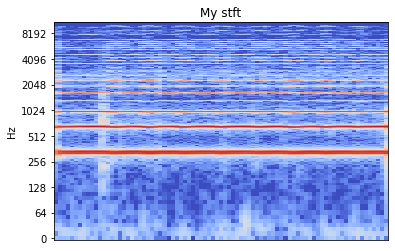

In [18]:
display.specshow(librosa.amplitude_to_db(np.abs(my_sft)), y_axis='log')
plt.title(f'My stft')
plt.show()

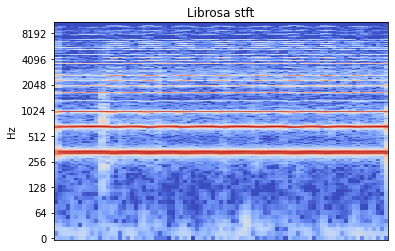

In [19]:
display.specshow(librosa.amplitude_to_db(np.abs(lib_sft)), y_axis='log')
plt.title('Librosa stft')
plt.show()

In [34]:
def get_random_signal(x: np.ndarray):
    return np.sin(x * np.random.randint(0, 10) + np.pi) + np.sin(x * np.random.randint(0, 10) + np.pi) + np.sin(x * np.random.randint(0, 10) + np.pi)

In [43]:
x = np.arange(0, 15, 0.01)
y1 = get_random_signal(x)
y2 = get_random_signal(x)
y3 = get_random_signal(x)

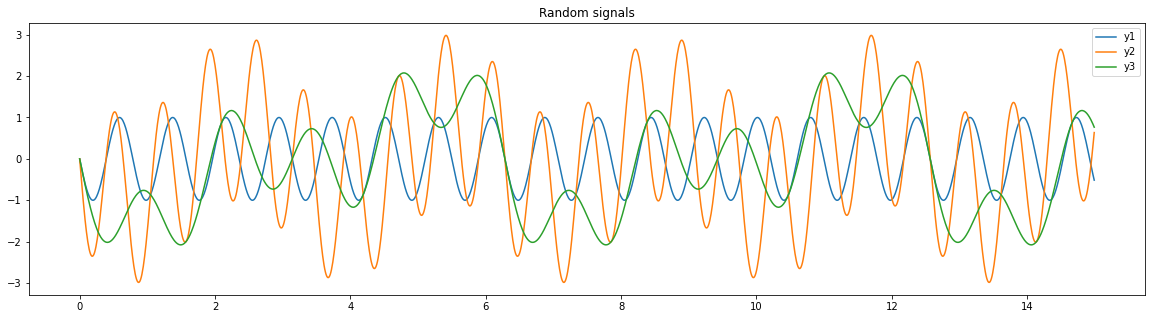

In [44]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Random signals')
ax.plot(x, y1, label='y1')
ax.plot(x, y2, label='y2')
ax.plot(x, y3, label='y3')
plt.legend()
plt.show()

In [60]:
import time
def test_signal(fun, sizes = [1e4, 1e5, 1e6], n_runs: int = 10, print_medi: bool = True):
    for size in sizes:
        times = []
        x = np.arange(size)
        if print_medi:
            print(f'\tStarted run with size {size}')
            print('\t' + '=' * 60)
        for i in range(n_runs):
            y = get_random_signal(x)
            t0 = time.time()
            _ = fun(y)
            t1 = time.time()
            time_diff = t1 - t0
            if print_medi:
                print(f'\tExecuted run {i + 1}/{n_runs} with size {size} in {round(time_diff, 6)}ms')
            times.append(time_diff)
        print(f'\tAVERAGE TIME FOR SIZE {size}: {round(np.mean(times), 6)} + {round(np.std(times), 6)}')
        print('\t' + '=' * 60)

In [59]:
fft1 = fft
fft2 = np.fft.fft
stft1 = lambda x: stft(x, FRAME_SIZE, HOP_SIZE, WINDOW_FUNCTION)
stft2 = lambda x: librosa.stft(x, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, window=WINDOW_FUNCTION, center=False) 

In [62]:
print('Mine FFT')
test_signal(fft1, sizes=[2 ** 10, 2 ** 11, 2 ** 12, 2 ** 13], print_medi=False)
print('\n' + '=' * 50 + '\n')

print('Numpy FFT')
test_signal(fft2, sizes=[2 ** 10, 2 ** 11, 2 ** 12, 2 ** 13], print_medi=False)
print('\n' + '=' * 50 + '\n')

print('Mine STFT')
test_signal(stft1, print_medi=False)
print('\n' + '=' * 50 + '\n')

print('Librosa STFT')
test_signal(stft2, print_medi=False)
print('\n' + '=' * 50 + '\n')

print('Mine STFT on real audio')
test_signal(stft1, sizes=[audio.shape[0]], print_medi=False)
print('\n' + '=' * 50 + '\n')

print('Librosa STFT on real audio')
test_signal(stft2, sizes=[audio.shape[0]], print_medi=False)
print('\n' + '=' * 50 + '\n')

Mine FFT
	AVERAGE TIME FOR SIZE 1024: 0.003004 + 0.001515
	AVERAGE TIME FOR SIZE 2048: 0.004213 + 0.000204
	AVERAGE TIME FOR SIZE 4096: 0.007793 + 0.000248
	AVERAGE TIME FOR SIZE 8192: 0.015702 + 0.000295


Numpy FFT
	AVERAGE TIME FOR SIZE 1024: 3e-05 + 3e-05
	AVERAGE TIME FOR SIZE 2048: 2.4e-05 + 1.5e-05
	AVERAGE TIME FOR SIZE 4096: 4.1e-05 + 2e-06
	AVERAGE TIME FOR SIZE 8192: 7.9e-05 + 1e-06


Mine STFT
	AVERAGE TIME FOR SIZE 10000.0: 0.060896 + 0.000431
	AVERAGE TIME FOR SIZE 100000.0: 0.742006 + 0.010898
	AVERAGE TIME FOR SIZE 1000000.0: 7.369397 + 0.009754


Librosa STFT
	AVERAGE TIME FOR SIZE 10000.0: 0.000302 + 6.6e-05
	AVERAGE TIME FOR SIZE 100000.0: 0.001873 + 5e-06
	AVERAGE TIME FOR SIZE 1000000.0: 0.018292 + 0.000526


Mine STFT on real audio
	AVERAGE TIME FOR SIZE 44100: 0.313951 + 0.000864


Librosa STFT on real audio
	AVERAGE TIME FOR SIZE 44100: 0.000891 + 3.8e-05


